# Comprehensive Overview and Generalization of Neural Network Models for Multivariate Time Series Forecasting

## Notebook Overview
This notebook consolidates and compares the neural network architectures developed for multivariate time series forecasting, including autoencoders, standard LSTM and LSTM-based autoencoder.
It aims to summarize the preprocessing steps, model designs, and validation techniques employed, highlighting the strengths and limitations of each approach.
The goal is to provide a clear and practical reference for effectively applying neural network models to structured temporal data forecasting problems.

In [1]:
import pandas as pd
import numpy as np
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from utils import plots as plt

In [2]:
# Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

df1 = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

df2 = pd.concat([building_2_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Se necessario replicare i dati esterni per il numero totale di righe
if len(external_data) != len(building_2_3_data):
    n_repeats = int(len(building_2_3_data) / len(external_data))
    external_data = pd.concat([external_data] * n_repeats, axis=0, ignore_index=True)

# Unione finale: building + dati esterni
final_df = pd.concat([building_2_3_data.reset_index(drop=True), external_data.reset_index(drop=True)], axis=1)

X = final_df[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

_, real = train_test_split(X_scaled, test_size=0.3, random_state=7)

In [3]:
def create_lstm_input(data, timesteps):
    X_seq = []
    for i in range(len(data) - timesteps + 1):
        X_seq.append(data[i:i+timesteps])
    return np.array(X_seq)

def create_lstm_input_with_target(data, timesteps):
    X_seq, y = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X_seq), np.array(y)

## Building 1 for training, Building 2&3 for testing
All the models used for prediction are trained on the Building 1 data, each in its own dedicated notebook.  
For evaluation, the models are tested on the combined dataset of Building 2 and Building 3.  
For the LSTM and Autoencoder-LSTM models, the input data must be adapted into sequences of fixed length (timesteps), which requires reshaping the scaled features into a 3D structure of shape (samples, timesteps, features).

14/14 [==============================] - 1s 2ms/step


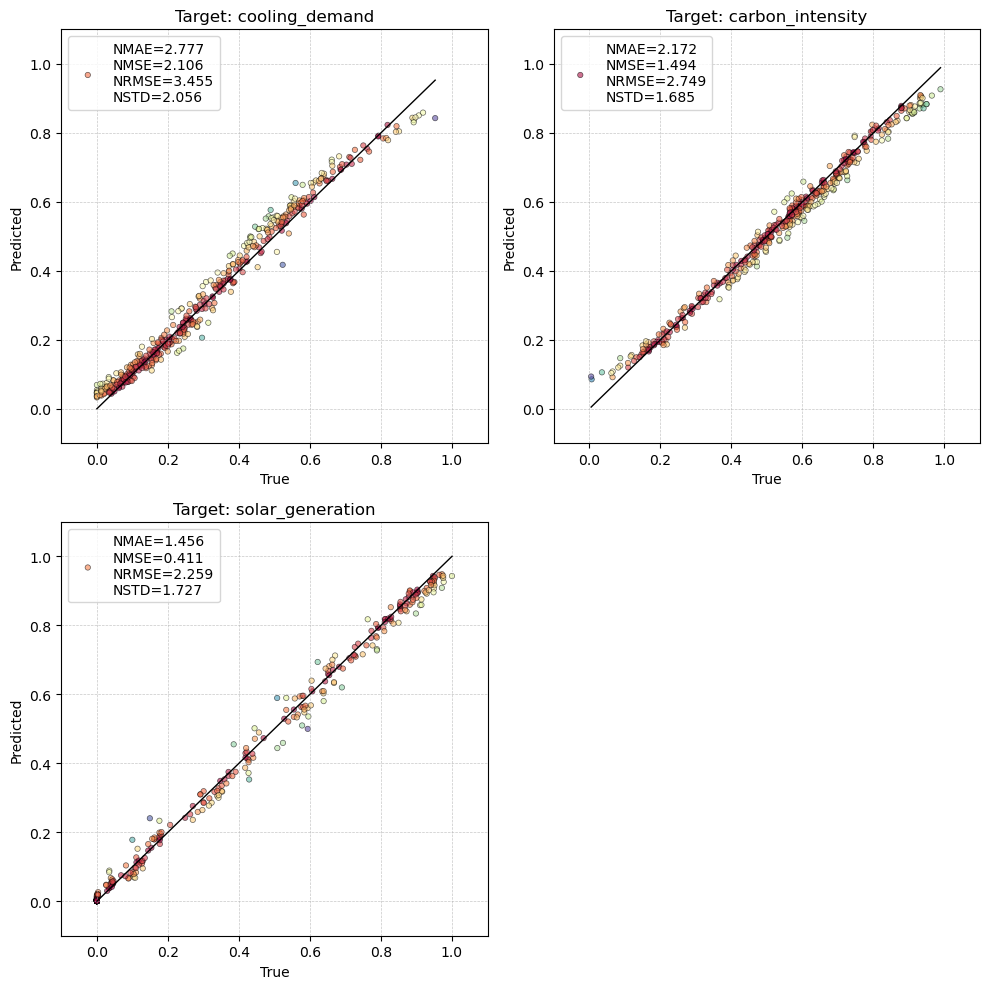

In [4]:
model = load_model("..\\reports\\models\\autoencoder_generalization.h5")
pred_aer = model.predict(real)
plt.plot_targets(real, pred_aer, targets, features, percent=True, filename="autoencoder_generalization.png")

14/14 [==============================] - 1s 2ms/step


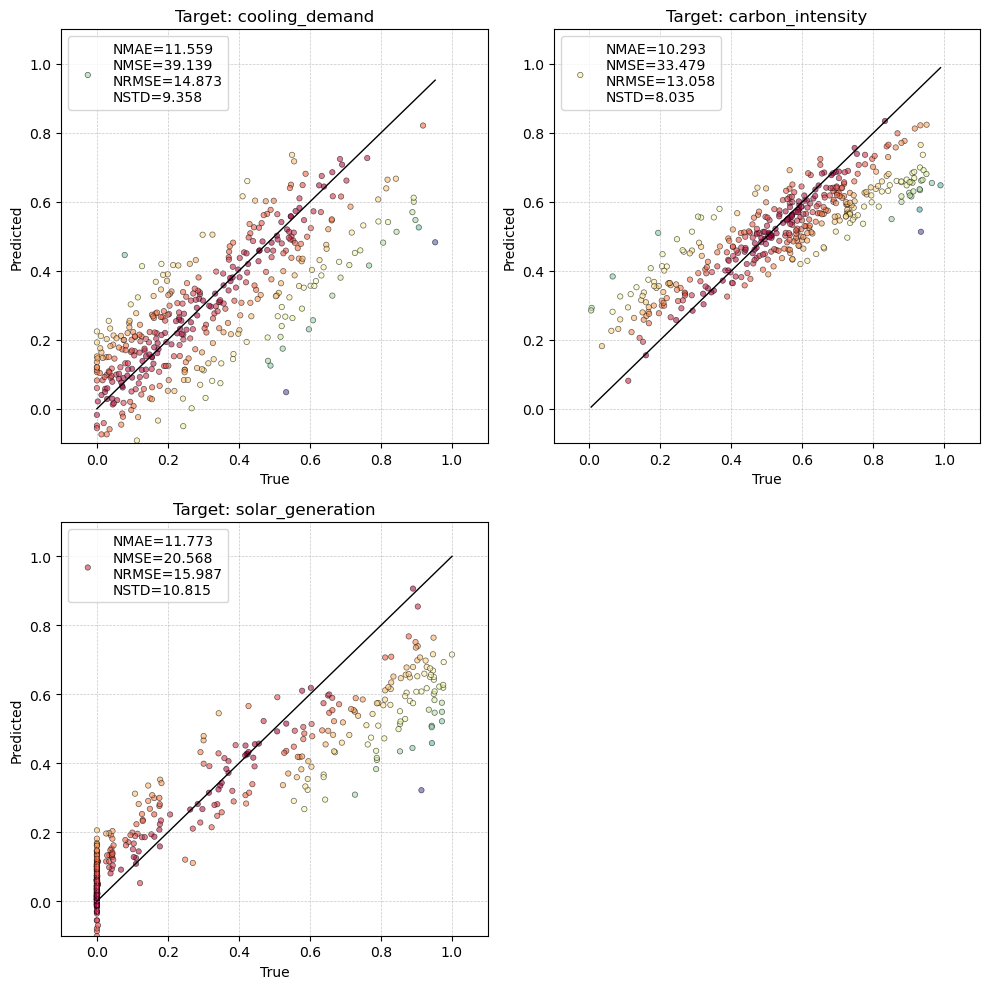

In [5]:
model = load_model("..\\reports\\models\\lstm_generalization.h5")
timesteps = 12
X_real_seq = create_lstm_input(real, timesteps=timesteps) # Create sequential input data with a window size of 3 timesteps
pred_lstm = model.predict(X_real_seq) 
real_seq_aligned = real[timesteps-1:, :] # Since the first prediction corresponds to timestep 3 (index 2), we drop the first 2 rows from the real data
plt.plot_targets(real_seq_aligned, pred_lstm, targets, features, percent=True, filename="lstm_generalization.png")

14/14 [==============================] - 0s 6ms/step


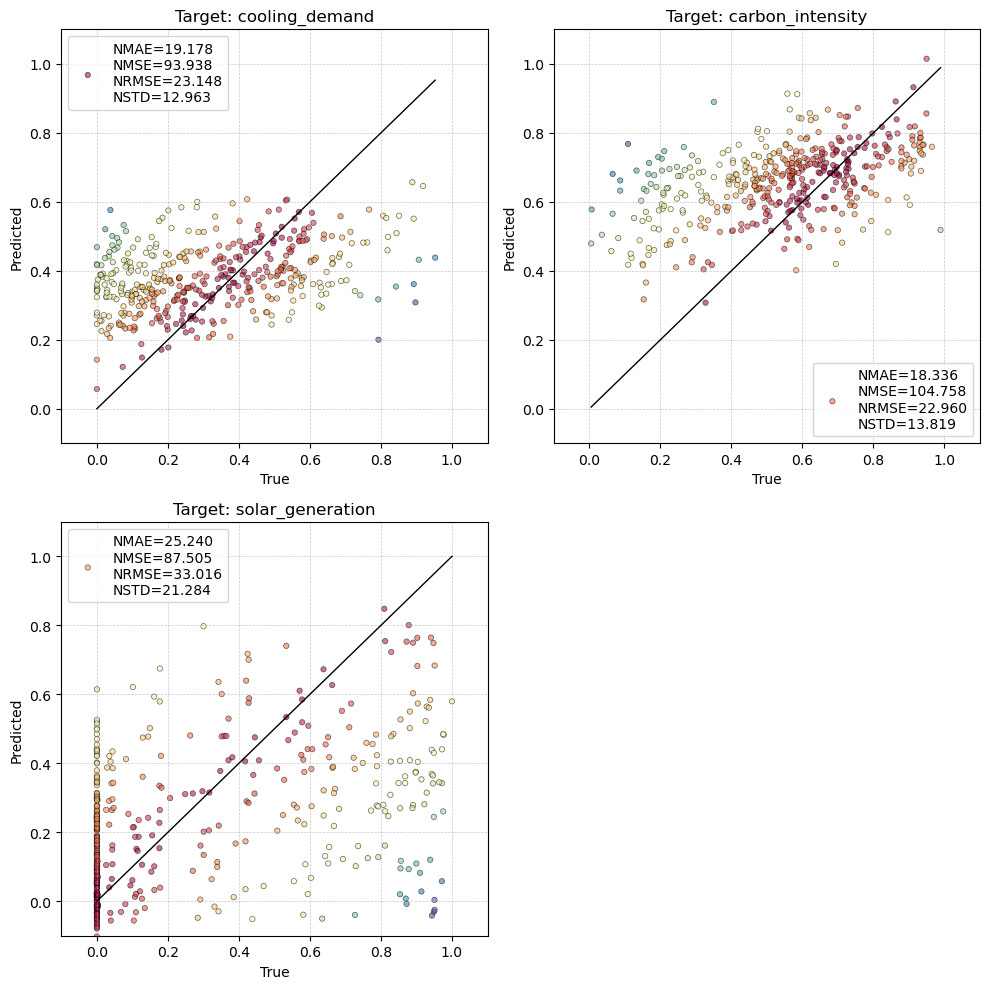

In [6]:
model = load_model("..\\reports\\models\\autoencoderLSTM_generalization.h5")
X_real_seq = create_lstm_input(real, timesteps=6) # Create sequential input data with a window size of 6 timesteps
pred_ael = model.predict(X_real_seq)
plt.plot_aelstm_targets(X_real_seq, pred_ael, targets, features, percent=True, filename="autoencoderLSTM_generalization.png")

## Tuning and Training with K-Fold Cross-Validation

23/23 [==============================] - 0s 1ms/step


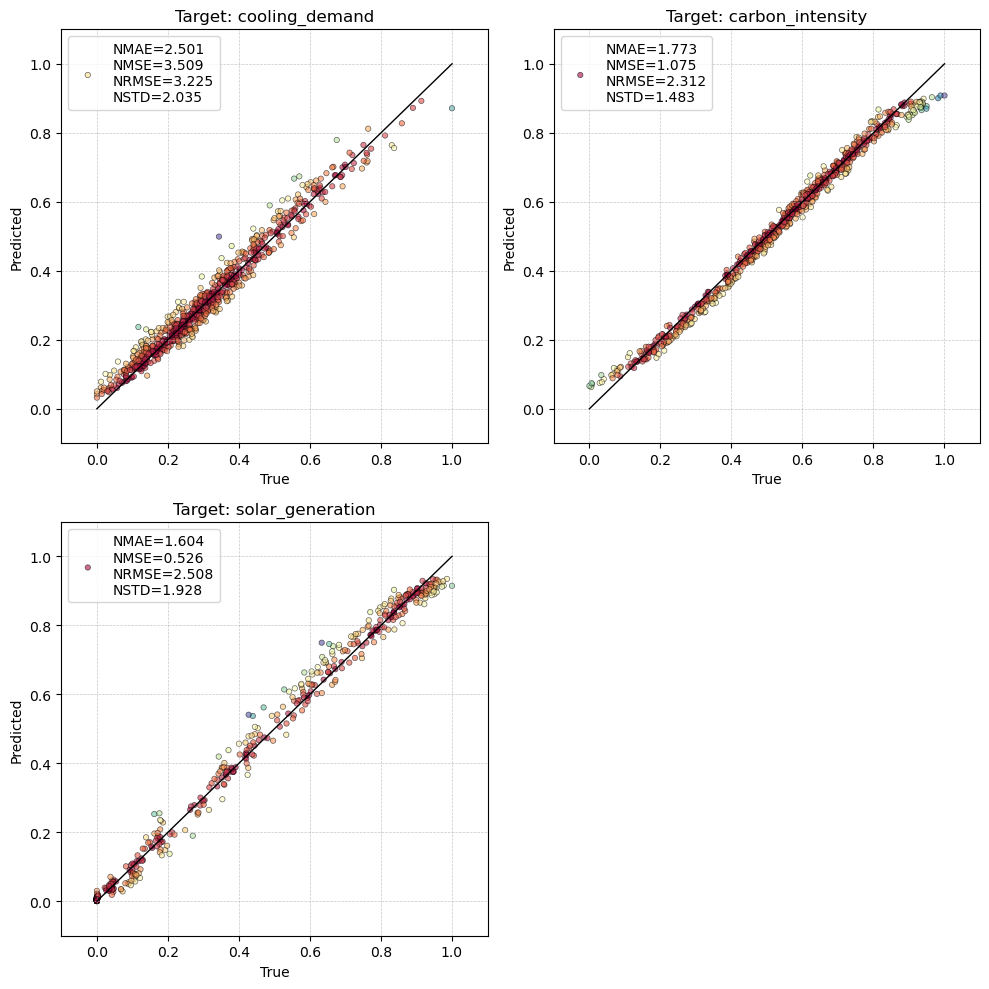

In [7]:
model = load_model("..\\reports\\models\\autoencoder_kfoldtuning.h5")
X_scaled = scaler.fit_transform(df1[features])
plt.plot_targets(X_scaled, model.predict(X_scaled), targets, features, percent=True, filename="autoencoder_kfoldtuning.png")

23/23 [==============================] - 0s 2ms/step


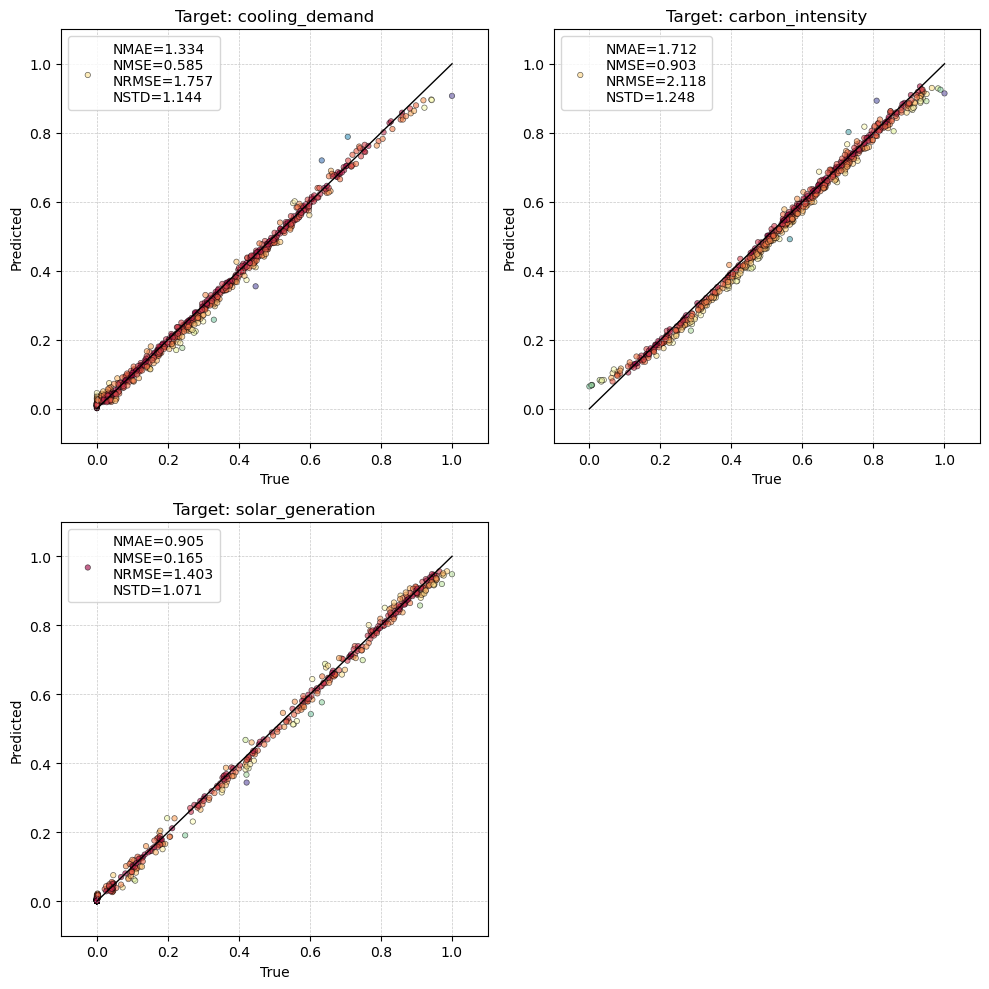

In [8]:
model = load_model("..\\reports\\models\\autoencoder_kfoldtrain.h5")
X_scaled = scaler.fit_transform(df2[features])
plt.plot_targets(X_scaled, model.predict(X_scaled), targets, features, percent=True, filename="autoencoder_kfoldtrain.png")

23/23 [==============================] - 0s 2ms/step


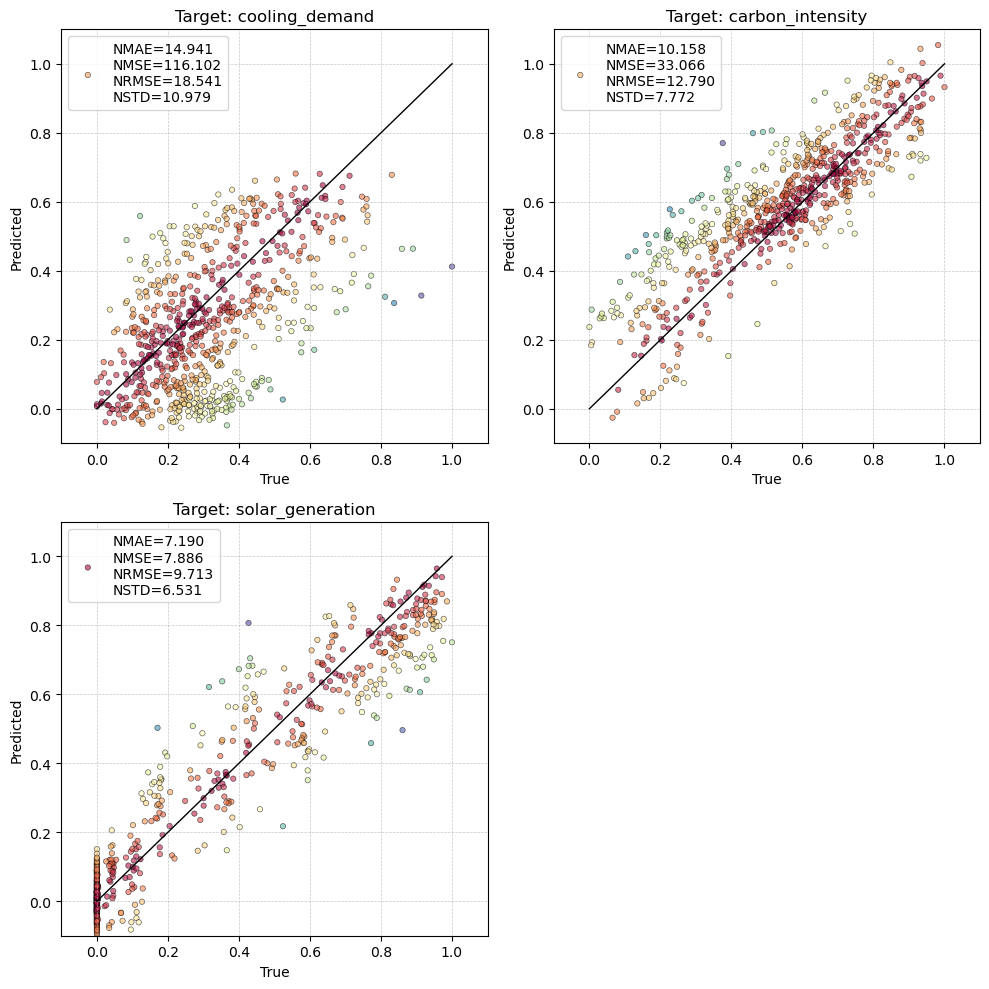

In [9]:
model = load_model("..\\reports\\models\\lstm_kfoldtuning.h5")
X_scaled = scaler.fit_transform(df1[features])
X_seq, y_real = create_lstm_input_with_target(X_scaled, 3) # Create sequential input data with a window size of 3 timesteps
y_pred = model.predict(X_seq)
plt.plot_targets(y_real, y_pred, targets, features, percent=True, filename="lstm_kfoldtuning.png")

23/23 [==============================] - 0s 2ms/step


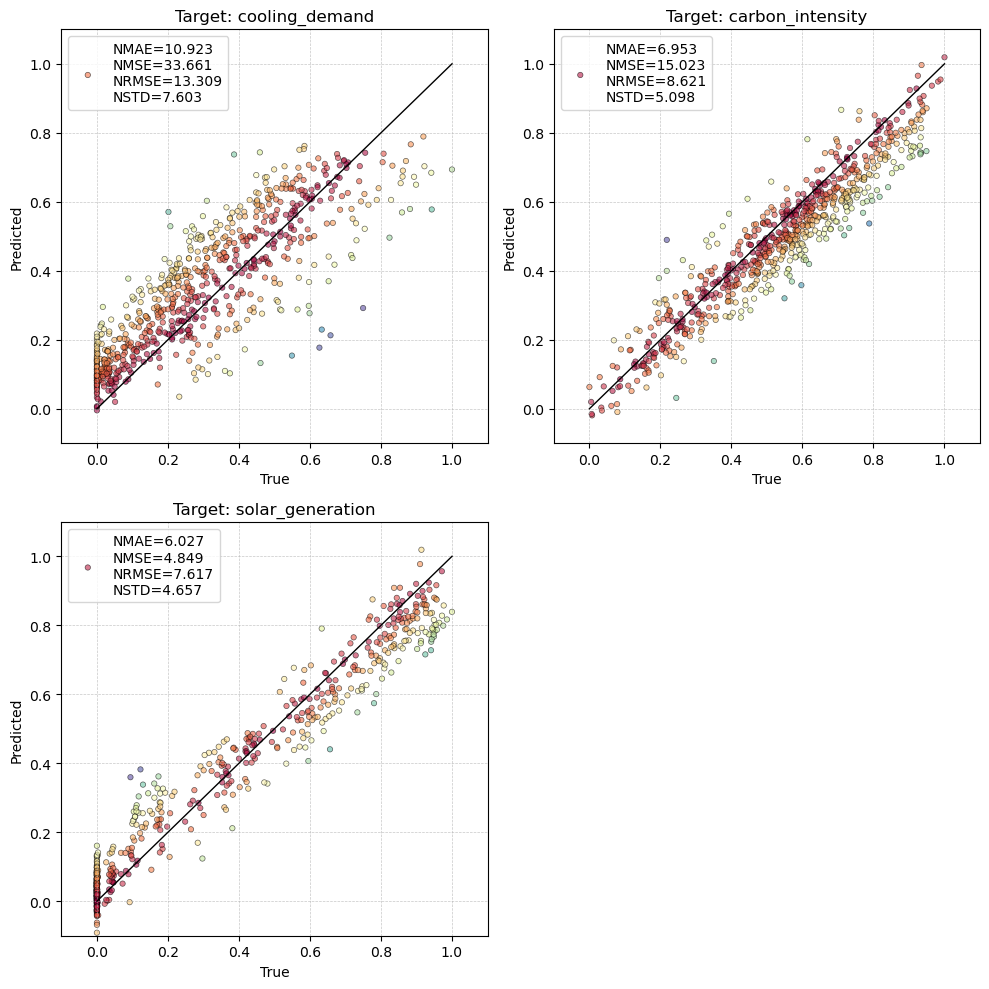

In [10]:
model = load_model("..\\reports\\models\\lstm_kfoldtrain.h5")
X_scaled = scaler.fit_transform(df2[features])
X_seq, y_real = create_lstm_input_with_target(X_scaled, 3) # Create sequential input data with a window size of 3 timesteps
y_pred = model.predict(X_seq)
plt.plot_targets(y_real, y_pred, targets, features, percent=True, filename="lstm_kfoldtrain.png")

23/23 [==============================] - 0s 5ms/step


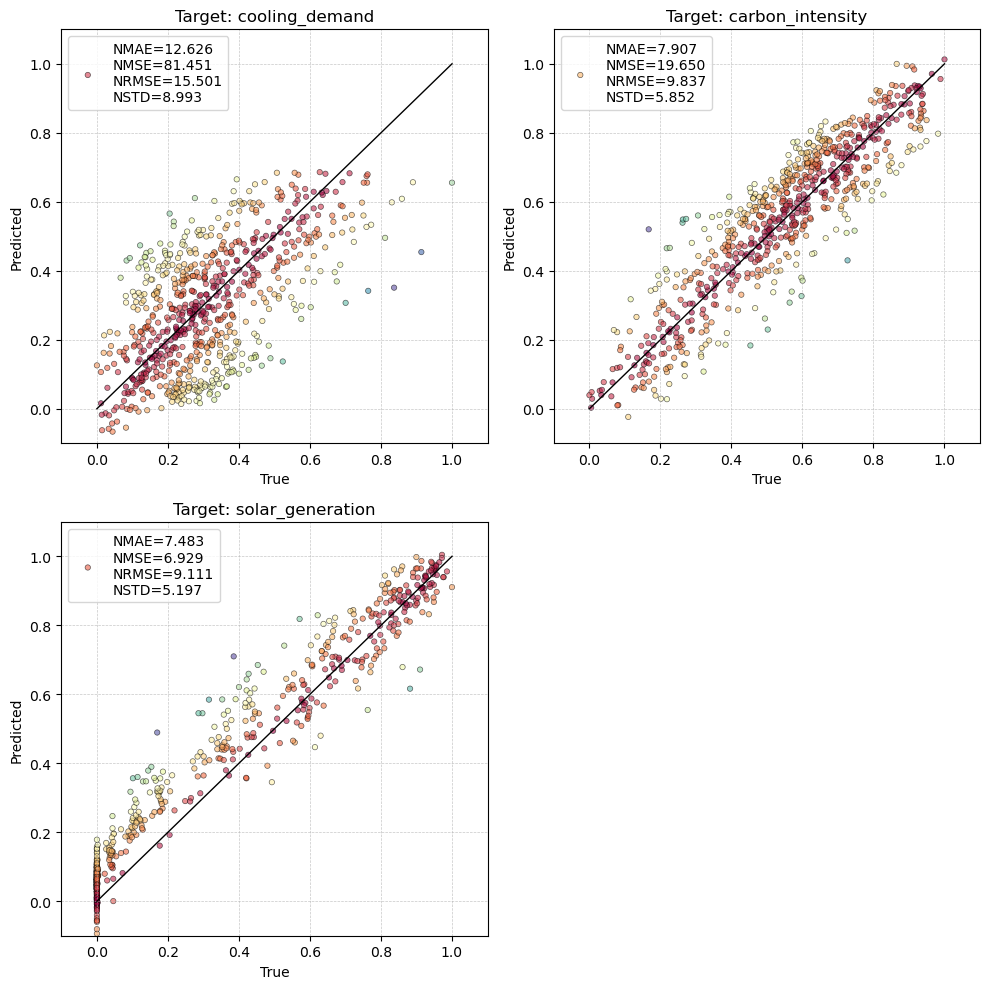

In [11]:
model = load_model("..\\reports\\models\\autoencoderLSTM_kfoldtuning.h5")
X_scaled = scaler.fit_transform(df1[features])
X_seq, y_real = create_lstm_input_with_target(X_scaled, 6) # Create sequential input data with a window size of 6 timesteps
y_pred = model.predict(X_seq)
plt.plot_aelstm_targets(X_seq, y_pred, targets, features, percent=True, filename="autoencoderLSTM_kfoldtuning.png")

23/23 [==============================] - 0s 5ms/step


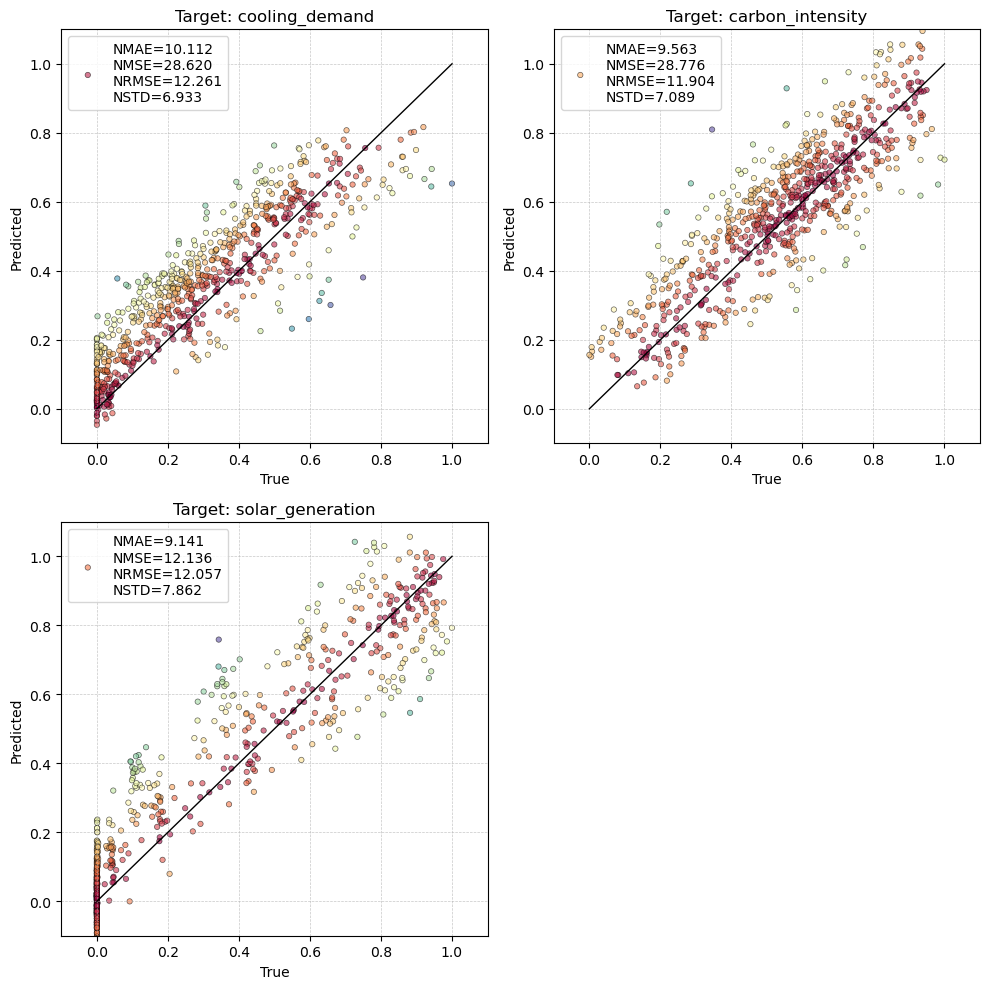

In [12]:
model = load_model("..\\reports\\models\\autoencoderLSTM_kfoldtrain.h5")
X_scaled = scaler.fit_transform(df2[features])
X_seq, y_real = create_lstm_input_with_target(X_scaled, 6) # Create sequential input data with a window size of 6 timesteps
y_pred = model.predict(X_seq)
plt.plot_aelstm_targets(X_seq, y_pred, targets, features, percent=True, filename="autoencoderLSTM_kfoldtrain.png")